# IN CLASS COMPETITION: NEURAL NETWORK

The coal mill is an essential auxiliary system in a thermal power plant. Its main job is to grind chunks of coal into fine powder that meets the required specs. This powdered coal is then carried by the primary air fan into the furnace, where it burns and heats water into superheated steam. That steam is what drives the turbine to generate electricity.

For this experiment, we’re using steady-state data from a medium-speed coal mill at a certain power plant. The parameters we've extracted include:
1. Coal mill current (in amps): This indicates how much electrical current the mill is drawing. Assuming voltage and power factor stay the same, it reflects the power consumption.
2. Coal mill output (in tons per hour): This tells us how much qualified coal powder the mill is producing.
3. Primary air flow (in tons per hour): This is the amount of air going into the mill, which helps carry the coal powder into the furnace for combustion.
4. Primary air temperature (in °C): This is the temperature of the air entering the mill.
5. Primary air differential pressure (in kPa): This is the pressure difference between the air entering and exiting the mill, which can give insight into the airflow resistance.

In this task, you'll be using a neural network. The goal is to predict the coal mill current based on a selection of other parameters. You’re free to choose any combination of the input variables—except the current itself, of course—as your model inputs.
Note: Since we’re working with steady-state data, there’s no direct connection between one data point and the next. Each row of data stands alone.

## LIBRARIES AND DATA IMPORT

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/bootcamp batch9/Steel Mill/Data4Train.csv')
data

,ID,Current,Load,Primary air flow,Primary air temperature,Difference of pressure
0,1,51.663,44.744,75.310,177.57,5.7999
1,2,51.578,45.417,76.458,179.09,5.9562
2,3,53.058,48.040,77.446,193.97,6.2132
3,4,53.431,48.369,77.805,193.77,6.2379
4,5,53.480,48.536,77.744,191.57,6.2647
...,...,...,...,...,...,...
9994,9995,56.091,48.917,78.869,191.65,4.3295
9995,9996,56.449,48.213,78.013,191.43,4.3007
9996,9997,56.303,47.540,78.044,190.85,4.2664
9997,9998,55.974,45.792,75.727,194.22,4.0771


In [ ]:
data.isnull().sum()

,0
ID,0
Current,0
Load,0
Primary air flow,0
Primary air temperature,0
Difference of pressure,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       9999 non-null   int64  
 1   Current                  9999 non-null   float64
 2   Load                     9999 non-null   float64
 3   Primary air flow         9999 non-null   float64
 4   Primary air temperature  9999 non-null   float64
 5   Difference of pressure   9999 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 468.8 KB


In [ ]:
data.describe()

,ID,Current,Load,Primary air flow,Primary air temperature,Difference of pressure
count,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000
mean,5000.000000,51.735624,47.672737,77.107503,220.854206,5.079082
std,2886.607005,3.404850,5.835428,4.894739,21.925155,1.367070
min,1.000000,40.353000,30.278000,63.042000,151.590000,2.425400
25%,2500.500000,49.433500,44.337000,73.758500,202.410000,4.036800
50%,5000.000000,51.663000,48.369000,77.693000,225.170000,4.593800
75%,7499.500000,54.008500,51.725000,80.561000,239.450000,6.155800
max,9999.000000,66.530000,65.622000,90.363000,261.760000,9.687700


REMARKS: We can see the inserted data have no nulls value and contain about 9999 instances with only 4 features. So, we'll proceed to Eploratory Data Analysis ahead.

## EXPLORATORY DATA ANALYSIS

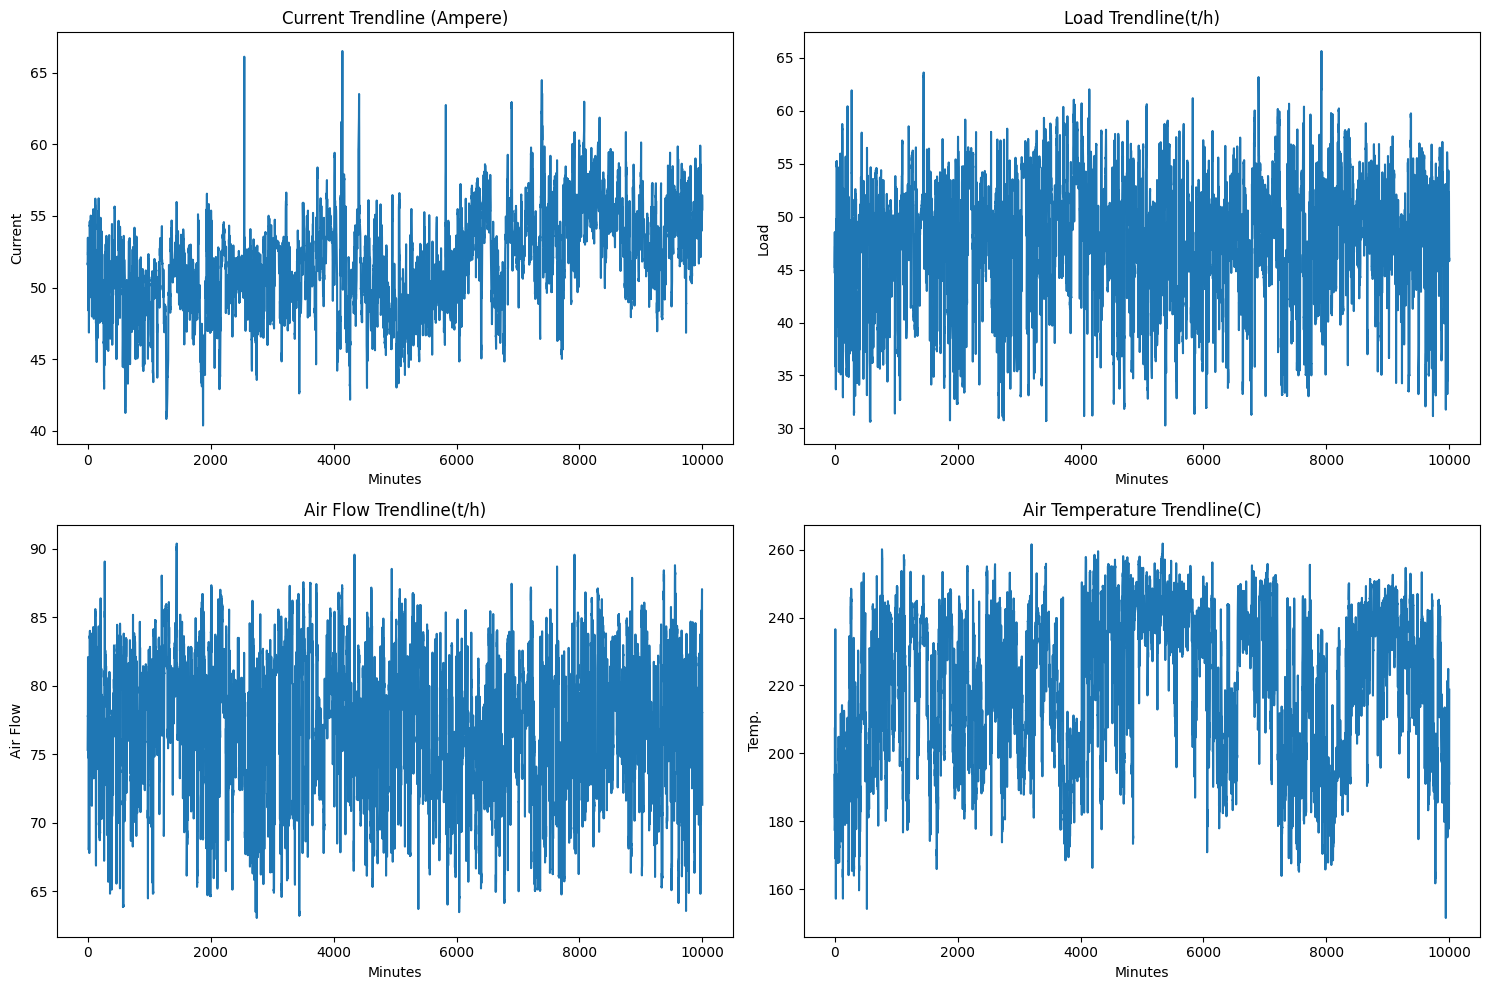

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.plot(data.index, data['Current'])
plt.title('Current Trendline (Ampere)')
plt.xlabel('Minutes')
plt.ylabel('Current')

plt.subplot(222)
plt.plot(data.index, data['Load'])
plt.title('Load Trendline(t/h)')
plt.xlabel('Minutes')
plt.ylabel('Load')

plt.subplot(223)
plt.plot(data.index, data['Primary air flow'])
plt.title('Air Flow Trendline(t/h)')
plt.xlabel('Minutes')
plt.ylabel('Air Flow')

plt.subplot(224)
plt.plot(data.index, data['Primary air temperature'])
plt.title('Air Temperature Trendline(C)')
plt.xlabel('Minutes')
plt.ylabel('Temp.')

plt.tight_layout()
plt.show()

REMARKS: The author state that this is a steady-state data, and therefore we did lineplot data and since there's no Date and Time-Stamp, we assume that the first data just taken at t=0 (it could be minutes or seconds if you want) until t=9999. We also observed that at some point in the trendline data, there are some spikes, and this can be considered as outliers. But we can't just delete these outliers because NN is 'data hungry' and therefore we'll cap this outliers.

In [ ]:
def rolling_iqr_capping(series, window=101, iqr_multiplier=1.5, fill=True):
    rolling_median = series.rolling(window=window, center=True).median()
    q1 = series.rolling(window=window, center=True).quantile(0.25)
    q3 = series.rolling(window=window, center=True).quantile(0.75)
    iqr = q3 - q1

    lower_band = rolling_median - iqr_multiplier * iqr
    upper_band = rolling_median + iqr_multiplier * iqr

    capped = series.copy()
    capped = capped.where(capped >= lower_band, lower_band)
    capped = capped.where(capped <= upper_band, upper_band)

    if fill:
        capped = capped.fillna(method='ffill').fillna(method='bfill')

    return capped

# Example usage
features_to_cap = ['Load', 'Primary air flow', 'Primary air temperature', 'Difference of pressure']

for col in features_to_cap:
  data[col + '_capped'] = rolling_iqr_capping(data[col], window=101)


/tmp/ipython-input-8-3802350741.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  capped = capped.fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-8-3802350741.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  capped = capped.fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-8-3802350741.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  capped = capped.fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-8-3802350741.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  capped = capped.fillna(method='ffill').fillna(method='bfill')


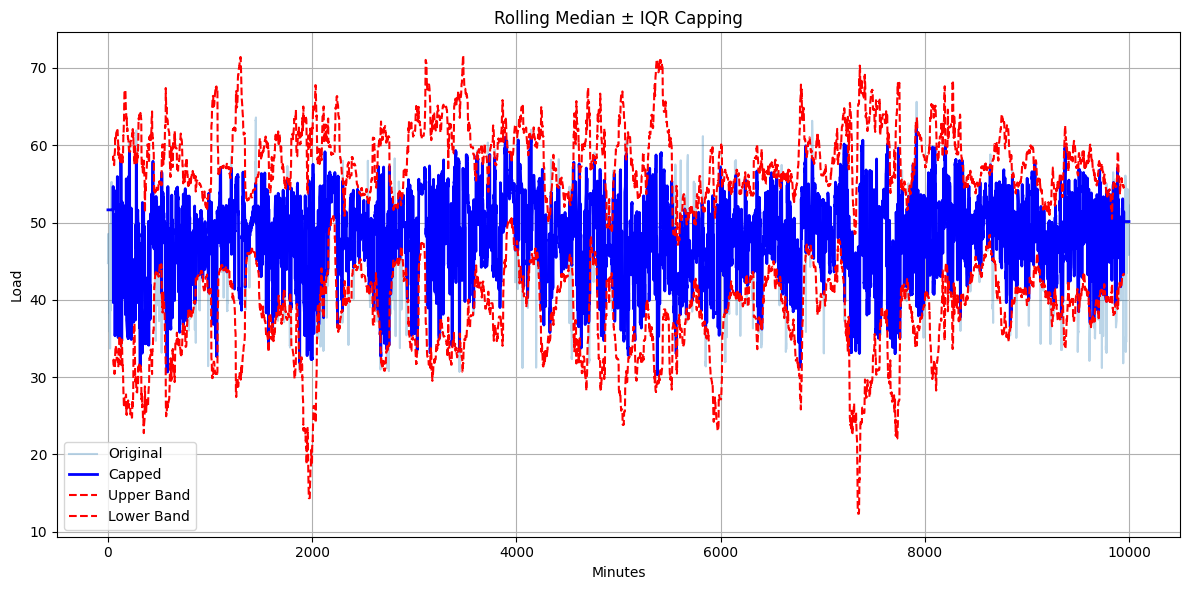

In [ ]:
# Recompute bands for plotting
rolling_median = data['Load'].rolling(window=101, center=True).median()
rolling_q1 = data['Load'].rolling(window=101, center=True).quantile(0.25)
rolling_q3 = data['Load'].rolling(window=101, center=True).quantile(0.75)
iqr = rolling_q3 - rolling_q1
lower_band = rolling_median - 1.5 * iqr
upper_band = rolling_median + 1.5 * iqr

plt.figure(figsize=(12, 6))
plt.plot(data['Load'], label='Original', alpha=0.3)
plt.plot(data['Load_capped'], label='Capped', color='blue', linewidth=2)
plt.plot(upper_band, label='Upper Band', color='red', linestyle='--')
plt.plot(lower_band, label='Lower Band', color='red', linestyle='--')
plt.title('Rolling Median ± IQR Capping')
plt.xlabel('Minutes')
plt.ylabel('Load')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

REMARKS: For visualization, you can see that we 'created' upper and lower limit on each instances for each features and check if that instance passes the limit or not, if it passes, then we capped the data. We also will drop the 'id' columns because it only contains unique nametag that doesn' have any contributions to data prediction in NN. After we capped the values, we'll also drop the original one and let the NN learns the capped data.

In [ ]:
data.drop(columns='ID', inplace=True)
data

,Current,Load,Primary air flow,Primary air temperature,Difference of pressure,Load_capped,Primary air flow_capped,Primary air temperature_capped,Difference of pressure_capped
0,51.663,44.744,75.310,177.57,5.7999,51.638,81.931,177.18,7.1672
1,51.578,45.417,76.458,179.09,5.9562,51.638,81.931,177.18,7.1672
2,53.058,48.040,77.446,193.97,6.2132,51.638,81.931,177.18,7.1672
3,53.431,48.369,77.805,193.77,6.2379,51.638,81.931,177.18,7.1672
4,53.480,48.536,77.744,191.57,6.2647,51.638,81.931,177.18,7.1672
...,...,...,...,...,...,...,...,...,...
9994,56.091,48.917,78.869,191.65,4.3295,50.125,81.618,187.74,4.2907
9995,56.449,48.213,78.013,191.43,4.3007,50.125,81.618,187.74,4.2907
9996,56.303,47.540,78.044,190.85,4.2664,50.125,81.618,187.74,4.2907
9997,55.974,45.792,75.727,194.22,4.0771,50.125,81.618,187.74,4.2907


In [ ]:
data['Primary air temperature_capped'].value_counts()

,count
Primary air temperature_capped,
187.74,52
177.18,52
237.42,8
217.50,7
238.64,7
...,...
206.07,1
209.50,1
224.92,1


In [ ]:
cols_to_drop = ['Load', 'Primary air flow', 'Primary air temperature', 'Difference of pressure']
data = data.drop(columns=cols_to_drop)
data

,Current,Load_capped,Primary air flow_capped,Primary air temperature_capped,Difference of pressure_capped
0,51.663,51.638,81.931,177.18,7.1672
1,51.578,51.638,81.931,177.18,7.1672
2,53.058,51.638,81.931,177.18,7.1672
3,53.431,51.638,81.931,177.18,7.1672
4,53.480,51.638,81.931,177.18,7.1672
...,...,...,...,...,...
9994,56.091,50.125,81.618,187.74,4.2907
9995,56.449,50.125,81.618,187.74,4.2907
9996,56.303,50.125,81.618,187.74,4.2907
9997,55.974,50.125,81.618,187.74,4.2907


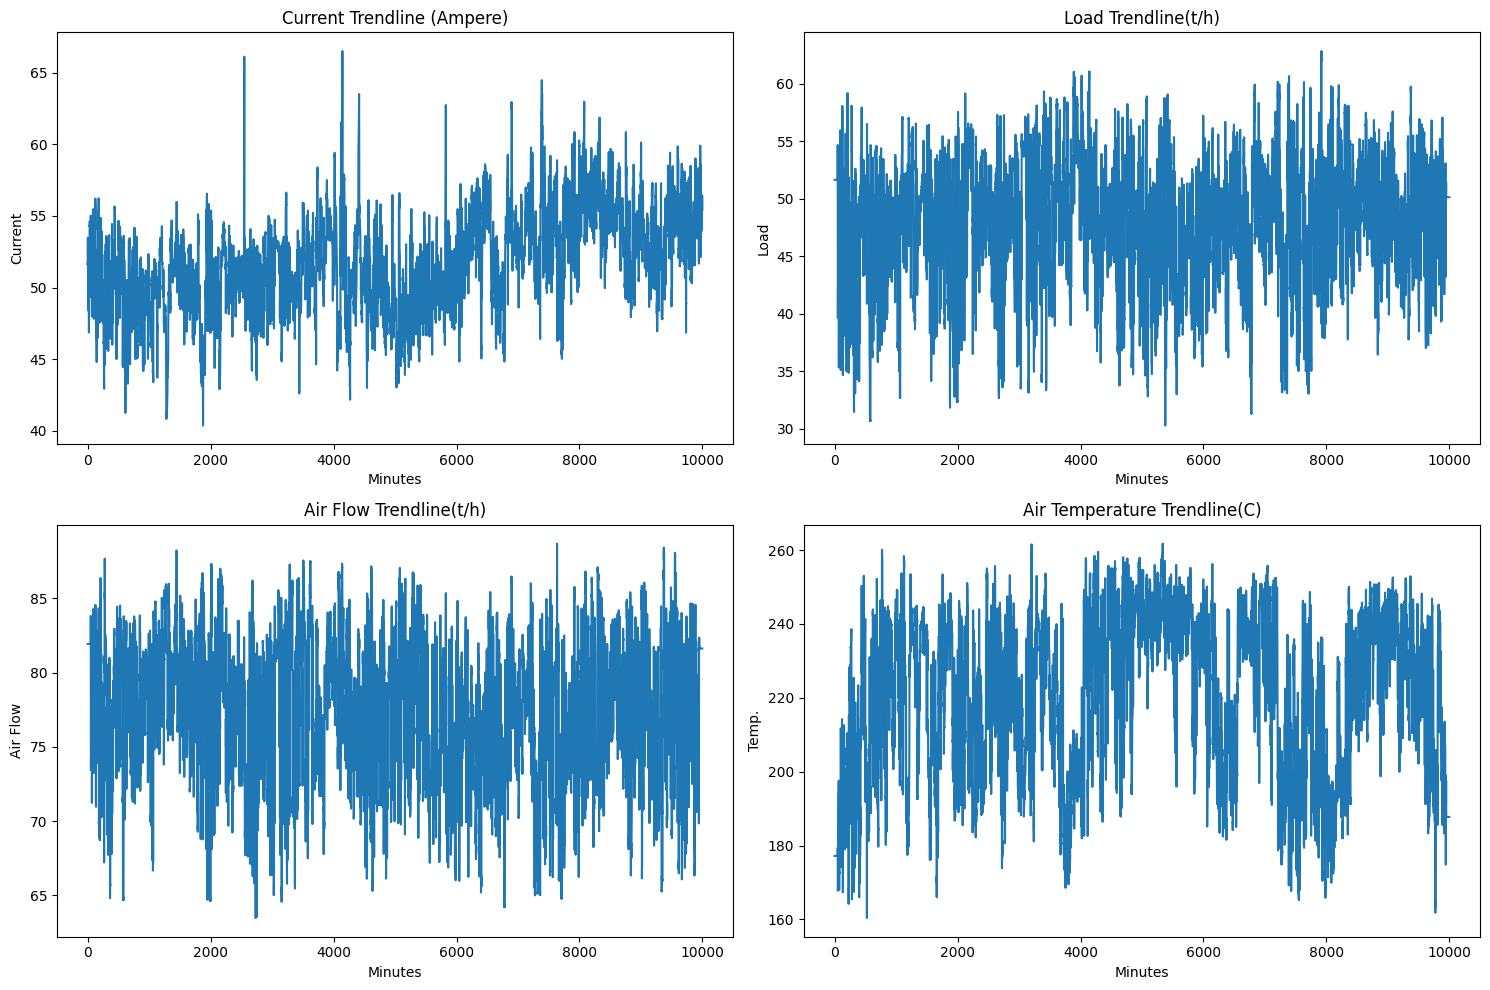

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.plot(data.index, data['Current'])
plt.title('Current Trendline (Ampere)')
plt.xlabel('Minutes')
plt.ylabel('Current')

plt.subplot(222)
plt.plot(data.index, data['Load_capped'])
plt.title('Load Trendline(t/h)')
plt.xlabel('Minutes')
plt.ylabel('Load')

plt.subplot(223)
plt.plot(data.index, data['Primary air flow_capped'])
plt.title('Air Flow Trendline(t/h)')
plt.xlabel('Minutes')
plt.ylabel('Air Flow')

plt.subplot(224)
plt.plot(data.index, data['Primary air temperature_capped'])
plt.title('Air Temperature Trendline(C)')
plt.xlabel('Minutes')
plt.ylabel('Temp.')

plt.tight_layout()
plt.show()

REMARKS: These are the trendline after we capped the features, we still can see some extremities, but the data clutter was much more reduced. We'll go ahead and proceed with NN modelling.

## NEURAL NETWORK MODELLING

First, we'll proceed to split the main data into 85% for training and 15% for testing. And among 85% of the train data, we take 17.7% for validation data in Neural Network. Next, we wil model the neural network with 1 input layer to receive data for 4 input features, followed by 2 Dense layer (64 nodes for the first and 32 for the second) and final output layer with 1 output node for regression result. The Neural Nets will be optimized with Adam methods.

In [ ]:
datrain, datest = train_test_split(data, test_size=0.15, random_state=42)
datrain

,Current,Load_capped,Primary air flow_capped,Primary air temperature_capped,Difference of pressure_capped
8700,54.319,47.198,76.8900,232.100,4.32100
3429,52.943,58.273,86.3485,253.240,4.76110
8869,56.517,47.728,77.0360,215.305,3.97330
5807,47.512,42.900,77.5330,238.290,5.45080
2088,51.791,47.490,76.9840,209.600,3.99170
...,...,...,...,...,...
5734,48.424,45.883,79.4100,241.790,6.04040
5191,48.291,43.332,78.2840,240.290,6.48770
5390,45.383,35.927,71.7550,233.250,4.88970
860,45.945,42.744,73.3085,233.540,3.57965


In [ ]:
# Apply only to input features
input_cols = ['Load_capped', 'Primary air flow_capped', 'Primary air temperature_capped', 'Difference of pressure_capped']
target_col = 'Current'

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(datrain[input_cols])
y_scaled = scaler_y.fit_transform(datrain[[target_col]])

# For training
X_train = X_scaled
y_train = y_scaled

In [ ]:
x_train_all, x_valid_all, y_train_all, y_valid_all = train_test_split(X_train, y_train, test_size=0.1765, random_state=42)

In [ ]:
print(x_train_all.shape)
print(y_train_all.shape)

print(x_valid_all.shape)
print(y_valid_all.shape)

(6998, 4)
(6998, 1)
(1501, 4)
(1501, 1)


In [ ]:
# optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
# optimizer =  keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model = keras.models.Sequential([
    keras.layers.Input(shape=x_train_all.shape[1:]),
    keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(1, activation='linear')
])
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[keras.metrics.RootMeanSquaredError()])
history = model.fit(x_train_all, y_train_all, epochs=100,
                    validation_data=(x_valid_all, y_valid_all))

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0291 - root_mean_squared_error: 0.1637 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0866
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071 - root_mean_squared_error: 0.0840 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0884
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0069 - root_mean_squared_error: 0.0832 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0807
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0066 - root_mean_squared_error: 0.0813 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0818
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0068 - root_mean_squared_error: 0.0825 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0847
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071 - root_mean_squared_error: 0.0839 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0801
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3m

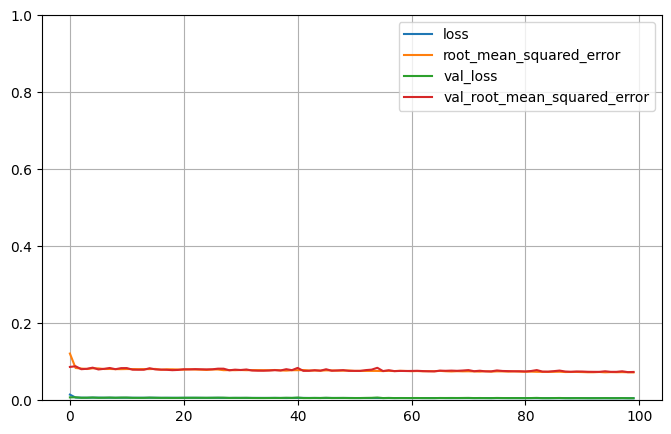

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
scaler_datest_x = MinMaxScaler()
scaler_datest_y = MinMaxScaler()

datest_x = scaler_datest_x.fit_transform(datest[input_cols])
datest_y = scaler_datest_y.fit_transform(datest[[target_col]])

x_test = datest_x
y_test = datest_y

pred_val = model.evaluate(x_test, y_test)
pred_val

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068 - root_mean_squared_error: 0.0821


[0.006824100390076637, 0.08260811120271683]

In [ ]:
print(data['Current'].min())
print(data['Current'].max())

40.353
66.53


In [ ]:
amp_range = data['Current'].max() - data['Current'].min()
real_rmse = 0.0821 * amp_range
real_rmse

2.1491317000000003

REMARKS: The GCA graphic looks good and we don't see any overfitting characteristic here. This model managed to predict the test data with RMSE of 0.0821 and coresspond to deviation of Current prediction of +/- 2.149A. We'll try to optimize by changing the optimizer parameter to NADAM with slower learning rate to ensure the model reach true convergence and add an extra network layer with 64 nodes.

In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model = keras.models.Sequential([
    keras.layers.Input(shape=x_train_all.shape[1:]),
    keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(1, activation='linear')
])
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[keras.metrics.RootMeanSquaredError()])
history = model.fit(x_train_all, y_train_all, epochs=100,
                    validation_data=(x_valid_all, y_valid_all))

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0139 - root_mean_squared_error: 0.1151 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0895
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0065 - root_mean_squared_error: 0.0808 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0793
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0065 - root_mean_squared_error: 0.0808 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0835
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0065 - root_mean_squared_error: 0.0806 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0796
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0063 - root_mean_squared_error: 0.0794 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0787
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0060 - root_mean_squared_error: 0.0776 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0778
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4m

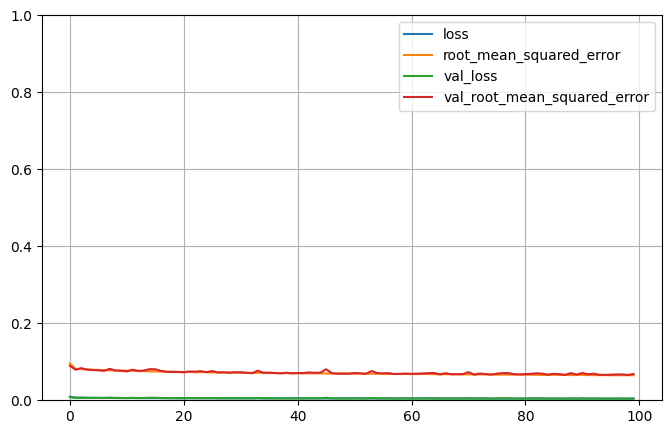

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
scaler_datest_x = MinMaxScaler()
scaler_datest_y = MinMaxScaler()

datest_x = scaler_datest_x.fit_transform(datest[input_cols])
datest_y = scaler_datest_y.fit_transform(datest[[target_col]])

x_test = datest_x
y_test = datest_y

pred_val = model.evaluate(x_test, y_test)
pred_val

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063 - root_mean_squared_error: 0.0791


[0.006246984004974365, 0.0790378674864769]

In [ ]:
amp_range = data['Current'].max() - data['Current'].min()
real_rmse = 0.0791 * amp_range
real_rmse

2.0706007

COMMENTS: With the Neural Network that has architecture of 1 input layer,followed by 3 Dense layer and final output layer with the Nadam optimization, we can achive RMSE 0.0791 that correspond to deviation in Current prediction of +/- 2.07A. It was observed that there are no overfitting in this case, and further lower RMSE may be obtained by exploring the Optimizer model and adding some nodes to the layers.